In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install visdom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408196 sha256=9b88d3389d77bc8c90286ffd767f9dd46809124d301137eee37f52418b2d1f57
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built visdom


In [3]:
import os

tj_dir = "/content/drive/MyDrive/colab_notebooks_shared"
wh_dir = "/content/drive/MyDrive/794"
ella_dir = "/content/drive/MyDrive/Colab Notebooks"

working_dir = wh_dir

os.chdir(working_dir)


# Training

In [ ]:
# Training
!python /content/drive/MyDrive/794_project/'Colab Notebooks'/main.py --model=deeplabv3_resnet50 --dataset=coco --batch_size=8 --total_itrs=3000

In [ ]:
# Visualization
!python /content/drive/MyDrive/794/main.py --test_only --save_val_results --model=deeplabv3_resnet50 --dataset=coco --ckpt=/content/drive/MyDrive/794_project/'Colab Notebooks'/checkpoints/latest_deeplabv3_resnet50_VOC_os16_lr0.pth


# Demo Pipeline

In [4]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,787 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [5]:
import network
import torch
from torch import nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import Image
import numpy as np
import matplotlib

from datasets import VOCSegmentation
import utils
from utils import ext_transforms as et


In [6]:
ckpt = f"{working_dir}/checkpoints/stop sign best/latest_deeplabv3_resnet50_VOC_os16_lr0.pth"


In [90]:
# img_path = f"{working_dir}/vandalized.jpg" # Vandalized good seg + bad OCR
img_path = f"{working_dir}/partially_occluded.jpg" # Good segmentation + bad OCR
# img_path = f"{working_dir}/night2.jpg" # Night + Good OCR
# img_path = f"{working_dir}/partially_destroyed.jpg" # small image
# img_path = f"{working_dir}/results/65_image.png"
# img_path = f"{working_dir}/results/33_image.png"


In [8]:
# Init model
model = network.modeling.__dict__["deeplabv3_resnet50"](
        num_classes=2, output_stride=16)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 264MB/s]


In [9]:
# Loading checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(ckpt, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["model_state"])
model = nn.DataParallel(model)
model.to(device)
print("Model restored from %s" % ckpt)
del checkpoint  # free memory

<ipython-input-9-0ea7ea9495ac>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt, map_location=torch.device('cpu'))


Model restored from /content/drive/MyDrive/794/checkpoints/stop sign best/latest_deeplabv3_resnet50_VOC_os16_lr0.pth


In [97]:
# Loading val image
transform = transforms.Compose([
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float),  # Converts to torch.float
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
              ])
image = Image.open(img_path)
img_tensor = transform(image)
print(img_tensor.shape)

torch.Size([3, 364, 434])


In [98]:
model.eval()
output = model(img_tensor.unsqueeze(0))
pred = output.detach().max(dim=1)[1].cpu().numpy()
pred = pred[0]
rows_with_true = np.where(np.any(pred, axis=1))[0]  # Rows with any non-zero values
cols_with_true = np.where(np.any(pred, axis=0))[0]  # Columns with any non-zero values
if rows_with_true.size > 0 and cols_with_true.size > 0:
    min_row, max_row = rows_with_true[0], rows_with_true[-1]
    min_col, max_col = cols_with_true[0], cols_with_true[-1]
else:
    # No non-zero values found
    min_row = max_row = min_col = max_col = None

print(f"Bounding box rows: {min_row} to {max_row}")
print(f"Bounding box columns: {min_col} to {max_col}")

Bounding box rows: 28 to 345
Bounding box columns: 31 to 386


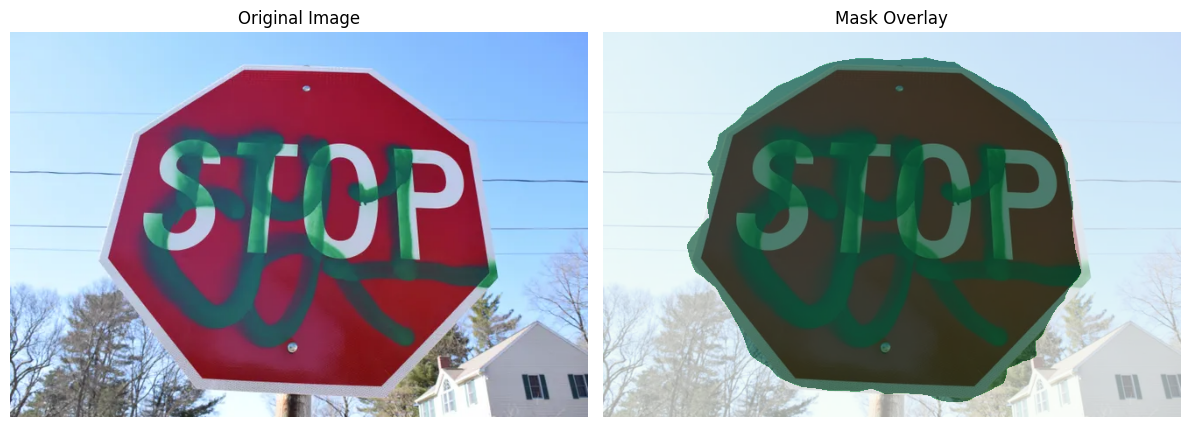

In [94]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(image) 
axes[1].imshow(pred, cmap='Greens', alpha=0.6)  
axes[1].set_title("Mask Overlay")
axes[1].axis("off")

if min_row is not None and min_col is not None:
    rect = Rectangle(
        (min_col, min_row),
        max_col - min_col + 1,
        max_row - min_row + 1,
        linewidth=2,
        edgecolor='blue',
        facecolor='none'
    )

# Display the plots
plt.tight_layout()
plt.show()


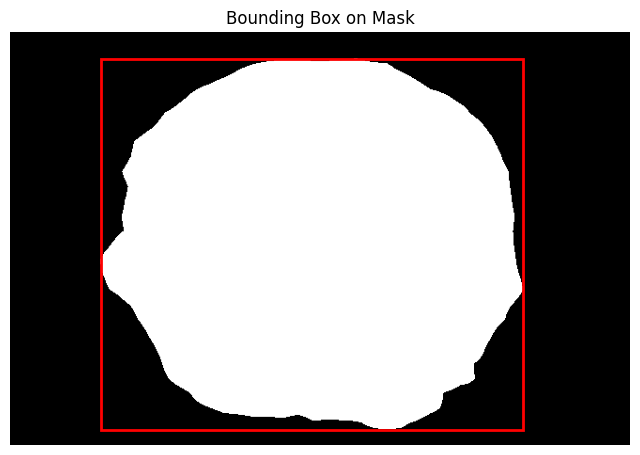

In [95]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(pred, cmap="gray") 

if min_row is not None and min_col is not None:
    rect = Rectangle((min_col, min_row), max_col - min_col + 1, max_row - min_row + 1,
                     linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.title("Bounding Box on Mask")
plt.axis("off")
plt.show()

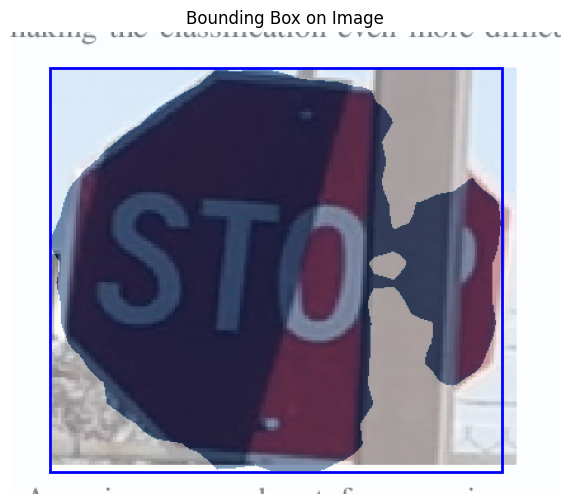

In [99]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(image)  
ax.imshow(pred, cmap='Blues', alpha=0.5) 

if min_row is not None and min_col is not None:
    rect = Rectangle((min_col, min_row), max_col - min_col + 1, max_row - min_row + 1,
                     linewidth=2, edgecolor='blue', facecolor='none')

    ax.add_patch(rect)

plt.title("Bounding Box on Image")
plt.axis("off")
plt.show()

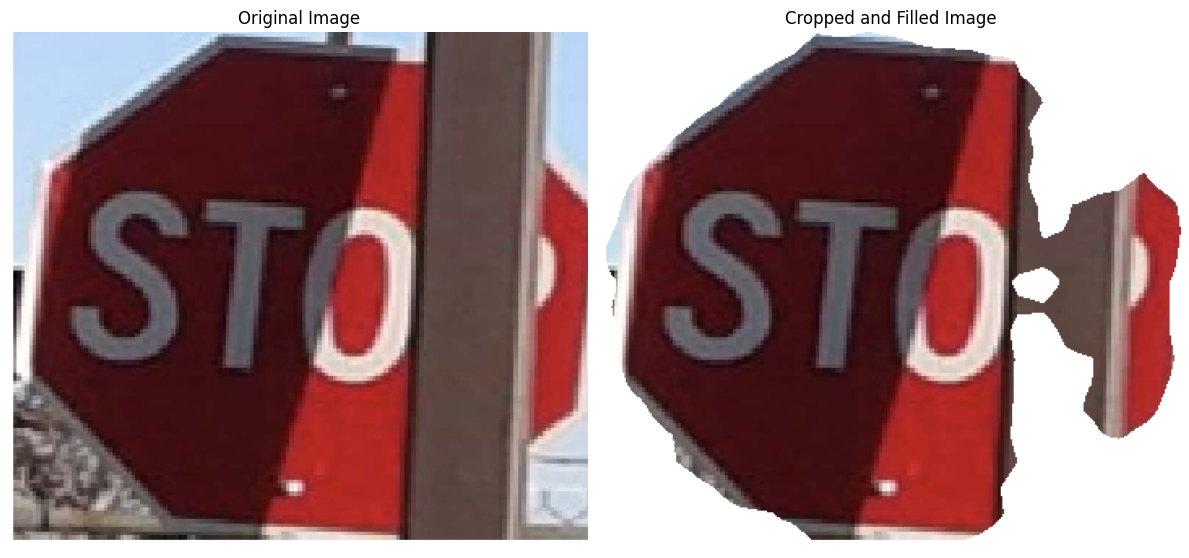

In [100]:
image_np = np.array(image)
cropped_image = image_np[min_row:max_row+1, min_col:max_col+1]
cropped_mask = pred[min_row:max_row+1, min_col:max_col+1]

non_mask_indices = cropped_mask == 0

filled_image = cropped_image.copy()
padded_image = np.pad(
    cropped_image,
    pad_width=((1, 1), (1, 1), (0, 0)),  
    mode='edge'
)
for i in range(filled_image.shape[0]):
    for j in range(filled_image.shape[1]):
        if non_mask_indices[i, j]:
            filled_image[i, j] = cropped_image[0,0]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(cropped_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(filled_image)
axes[1].set_title("Cropped and Filled Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [65]:
import pytesseract
from PIL import Image
import cv2
import numpy as np

(-0.5, 355.5, 317.5, -0.5)

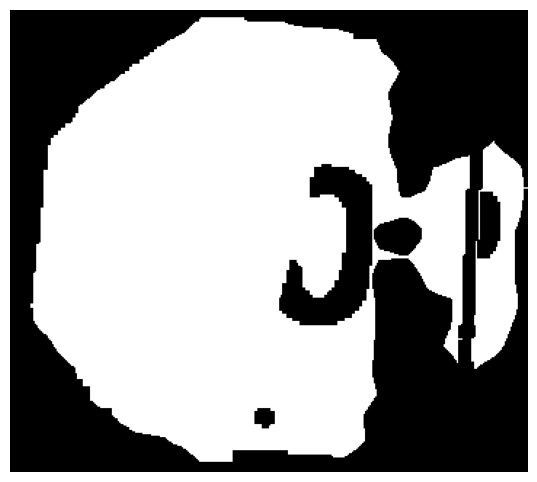

In [101]:
img = cv2.cvtColor(filled_image, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
count_white = np.sum(binary_image > 0)
count_black = np.sum(binary_image == 0)
if count_black > count_white:
    binary_image = 255 - binary_image

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  

# Apply erosion
binary_image = cv2.erode(binary_image, kernel, iterations=2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(binary_image,cmap="gray")
ax.axis("off")

In [87]:
word_image = binary_image.copy()
data = pytesseract.image_to_data(word_image, config='--psm 6', output_type=pytesseract.Output.DICT)
n_boxes = len(data['text'])
for i in range(n_boxes):
    word = data['text'][i].strip()
    # Only process non-empty words and if the confidence is more than 25
    if word and (int(float(data['conf'][i])) > 0) and len(word) > 2:
        print(f"Word detected is: {word}")
        x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
        print(x, y, w, h)
        offset = 50
        cv2.rectangle(word_image, (x+10, y + offset), (x + w+10, y + h - offset), (255, 255, 255), 2)
        cv2.putText(word_image, word, (x, y+offset), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

cv2.imwrite("processed_imgs/output_with_word_boxes.png", word_image)

True

In [88]:
results = pytesseract.image_to_string(binary_image, config='--psm 6')

print("Text detected:")
print(results)

Text detected:
g bg °



(-0.5, 449.5, 393.5, -0.5)

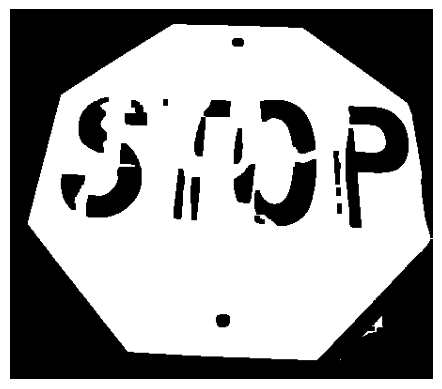

In [89]:
# VIsualize the output with word boxes
plt.imshow(word_image, cmap="gray")
plt.axis("off")

# THANK YOU FOR WATCHING OUR DEMO!